# Main Script to Load, Transform and Analyse data for Final Assigment

## Data load from local file "HM Land Registry - Price Paid Data property sales in Greater London - Raw Data.csv"

# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import locale # Used 
import yaml # Used to manage configuration Parameters, I'm using it at work and it's so easy to set configurable constant values 

# Loading config file

In [2]:
cnf_file = open(f"config.yaml", 'r')
conf_dictionary = yaml.full_load(cnf_file)
config = conf_dictionary["default"]

# Load data from CSV file

In [3]:
df1 = pd.read_csv("Property sales in Greater London - 2018 - 2019.csv", parse_dates=[config['parse_dates']])
df2 = pd.read_csv("Property sales in Greater London - 2020 - 2023.csv", parse_dates=[config['parse_dates']])

# Merging both dataframes

In [4]:
df = pd.concat([df1, df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489352 entries, 0 to 287274
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   unique_id             489352 non-null  object        
 1   price_paid            489352 non-null  int64         
 2   deed_date             489352 non-null  datetime64[ns]
 3   postcode              488916 non-null  object        
 4   property_type         489352 non-null  object        
 5   new_build             489352 non-null  object        
 6   estate_type           489352 non-null  object        
 7   saon                  183047 non-null  object        
 8   paon                  489352 non-null  object        
 9   street                489312 non-null  object        
 10  locality              31256 non-null   object        
 11  town                  489352 non-null  object        
 12  district              489352 non-null  object        
 13 

# Renaming columns from both DFs

In [5]:
keys   = ['unique_id','price_paid','deed_date','postcode','property_type','new_build','estate_type','saon','paon','street','locality','town','district','county','transaction_category','linked_data_uri']
values = ['Id','Value','Purchased Date','Postcode','Property Type','New Build','Estate Type','Saon','Paon','Street','Locality','Town','District','County','Transaction Category','URL']
dict_cols = dict(zip(keys, values))
df.rename(columns=dict_cols, inplace=True)
col_order = ['Id','Purchased Date','Postcode','Property Type','Value','New Build','Estate Type','Transaction Category','Saon','Paon','Street','Locality','Town','District','County','URL']
df = df[col_order]

In [6]:
df['Purchased Date']

0        2018-11-30
1        2019-12-09
2        2019-10-16
3        2018-11-23
4        2019-07-05
            ...    
287270   2020-01-21
287271   2020-02-07
287272   2020-08-28
287273   2021-02-19
287274   2020-10-30
Name: Purchased Date, Length: 489352, dtype: datetime64[ns]

# Explore the data

In [7]:
print("Dataframe head:")
print(df.head())

print("Dataframe shape:")
print(df.shape )

print("Dataframe columns:")
print(df.columns)


Dataframe head:
                                     Id Purchased Date Postcode Property Type  \
0  7E86B6FB-423C-458C-E053-6B04A8C0C84C     2018-11-30  BR1 1AA             F   
1  9DBAD222-2B0C-6EB3-E053-6B04A8C0F257     2019-12-09  BR1 1AB             F   
2  965B6D91-D514-95E4-E053-6C04A8C07729     2019-10-16  BR1 1AE             F   
3  7E86B6FB-4232-458C-E053-6B04A8C0C84C     2018-11-23  BR1 1AF             F   
4  9FF0D96A-1CCA-11ED-E053-6C04A8C06383     2019-07-05  BR1 1AF             F   

    Value New Build Estate Type Transaction Category         Saon  \
0   99000         N           L                    A      FLAT 28   
1  445000         N           L                    A  APARTMENT 1   
2  255000         N           L                    B       FLAT 2   
3  400000         N           L                    A      FLAT 12   
4  380000         N           L                    A      FLAT 14   

                      Paon        Street Locality     Town District  \
0          

# Index of Property Market - Yearly Variation

### Convert date column to datetime format, set it as index and create a Year column out of it

In [8]:
df['Purchased Date'] = pd.to_datetime(df['Purchased Date'])
df.set_index('Purchased Date', inplace=True)
df['Year'] = df.index.year

### Set date column as the index

### Group data by year, aggregate by value and plot this

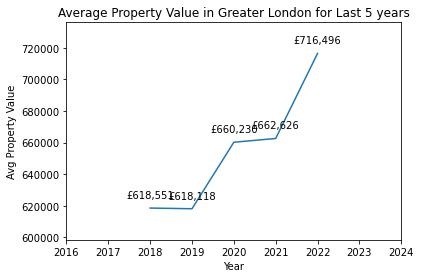

In [50]:
df_avg = df.groupby('Year')['Value'].mean()

# Set the locale to display the currency format
locale.setlocale(locale.LC_ALL, '')

plt.plot(df_avg.index, df_avg.values)
plt.xlabel('Year')
plt.ylabel('Avg Property Value')
plt.title('Average Property Value in Greater London for Last 5 years')
# zip joins x and y coordinates in pairs
plt.rcParams.update({'axes.ymargin': 0.2})
plt.rcParams.update({'axes.xmargin': 0.5})
for x,y in zip(df_avg.index, df_avg.values):

    label = "{:.0f}".format(y)
    label = locale.currency(y, grouping=True)[:-3]
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 annotation_clip=False) # horizontal alignment can be left, right or center

# for i, xy in enumerate(zip(df_avg.index, df_avg.values)):
#     plt.annotate(f' Point (%.0f, {locale.currency("%.3f")})' % xy, xy=xy)

# for xi, yi, text in zip(df_avg.index, df_avg.values, annotations):
#     ax.annotate(text,
#                 xy=(xi, yi), xycoords='data',
#                 xytext=(1.5, 1.5), textcoords='offset points')
plt.show()


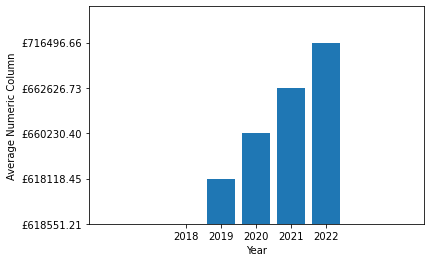

In [48]:

# Set the locale to display the currency format
locale.setlocale(locale.LC_ALL, '')

# Enumerate over the grouped data and format the values as currency
formatted_data = [(str(year), locale.currency(avg)) for year, avg in df_avg.iteritems()]

# Plot the data
pltb.bar(*zip(*formatted_data))
pltb.xlabel('Year')
pltb.ylabel('Average Numeric Column')
pltb.show()

### Calculate the average of a numeric column for each year

In [ ]:

grouped_by_year = df.asfreq('Y')


In [ ]:
averages_per_year = grouped_by_year['Value'].aggregate('mean')

In [ ]:
averages_per_year.head()

In [ ]:
# Compare annual avg price trends

In [ ]:
config['years_to_aggregate']

In [ ]:
avg_values = pd.DataFrame()

# Select data for each year and concatenate with avg. property values 
for year in years_to_aggregate:
    value_per_year = df.loc[year, ['Value']].reset_index(drop=True)
    value_per_year.rename(columns={'Value': year}, inplace=True)
    avg_values = pd.concat([prices, value_per_year], axis=1)

# Plot prices
avg_values.plot(subplots=True)
plt.tight_layout(); plt.show()
